# This notebook stands for exploratory data analysis (EDA) from which some insights from the data can be found.

In [1]:
!git clone https://github.com/OopsWrongCode/nlp-project.git

fatal: destination path 'nlp-project' already exists and is not an empty directory.


In [2]:
%cd nlp-project/

/kaggle/working/nlp-project


In [3]:
%pip install regex


Note: you may need to restart the kernel to use updated packages.


In [4]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os
import warnings

warnings.filterwarnings('ignore')

import nltk
nltk.download('popular')

[nltk_data] Downloading collection 'popular'
[nltk_data]    | 
[nltk_data]    | Downloading package cmudict to
[nltk_data]    |     /usr/share/nltk_data...
[nltk_data]    |   Package cmudict is already up-to-date!
[nltk_data]    | Downloading package gazetteers to
[nltk_data]    |     /usr/share/nltk_data...
[nltk_data]    |   Package gazetteers is already up-to-date!
[nltk_data]    | Downloading package genesis to
[nltk_data]    |     /usr/share/nltk_data...
[nltk_data]    |   Package genesis is already up-to-date!
[nltk_data]    | Downloading package gutenberg to
[nltk_data]    |     /usr/share/nltk_data...
[nltk_data]    |   Package gutenberg is already up-to-date!
[nltk_data]    | Downloading package inaugural to
[nltk_data]    |     /usr/share/nltk_data...
[nltk_data]    |   Unzipping corpora/inaugural.zip.
[nltk_data]    | Downloading package movie_reviews to
[nltk_data]    |     /usr/share/nltk_data...
[nltk_data]    |   Package movie_reviews is already up-to-date!
[nltk_data]  

True

In [5]:
from data.data_loader import loader

PATH = loader()
os.listdir(PATH)

Dataset downloaded at path: /kaggle/input/mbti-personality-type-twitter-dataset


['twitter_MBTI.csv']

In [6]:
file_path = os.path.join(PATH,os.listdir(PATH)[0])

In [7]:
df = pd.read_csv(file_path, index_col='Unnamed: 0')

In [8]:
from sklearn.model_selection import train_test_split


train, temp_df = train_test_split(df, test_size=0.3, stratify=df['label'], random_state=42)
valid, test = train_test_split(temp_df, test_size=0.5, stratify=temp_df['label'], random_state=42)

In [9]:
test.drop('label', axis=1, inplace=True)

In [10]:
train.head()

,text,label
7343,I checked in at Margie's Candies on #Yelp http...,intj
2908,So…Suga is next… we are still freaking out abo...,enfj
6310,you people don't understand henry creel like i...,infp
1392,@Ezysummers @beanyzilla @trailerparkbaby https...,enfp
1138,4k https://t.co/uIkBxpnCX4|||idk if i’ve ever ...,infj


In [11]:
# print(f"Shape of train : {train.shape}\nShape of validation : {valid.shape}\nShape of test : {test.shape}")

In [12]:
train['label'].value_counts(normalize=True).round(4)

label
infp    0.1641
infj    0.1354
intp    0.1039
intj    0.1001
enfp    0.0933
entp    0.0739
enfj    0.0662
isfp    0.0470
isfj    0.0466
istp    0.0419
entj    0.0357
istj    0.0331
esfp    0.0223
esfj    0.0134
estp    0.0128
estj    0.0104
Name: proportion, dtype: float64

In [13]:
train['token_count'] = [len(sentence.split()) for sentence in train['text']]
train['text_length'] = [len(seq) for seq in train['text']]

In [14]:
# df.iloc[55]['text']

In [15]:
print(f"Number of duplicates: {(len(train) - len(train.drop_duplicates(subset=['text'])))} ({round((len(train) - len(train.drop_duplicates(subset=['text']))) / len(train) * 100,2)}%)")
train = train.drop_duplicates(subset=['text'])

Number of duplicates: 133 (2.43%)


In [16]:
print(f"Number of duplicates: {(len(valid) - len(valid.drop_duplicates(subset=['text'])))} ({round((len(valid) - len(valid.drop_duplicates(subset=['text']))) / len(valid) * 100,2)}%)")
valid = valid.drop_duplicates(subset=['text'])

Number of duplicates: 6 (0.51%)


In [17]:
# import src.utils
# print(src.utils.re.__name__)

In [18]:
from src.utils import *

import regex as re

def clean_data(data):
    if not isinstance(data, str):
        return ""

    data = data.lower()
    data = re.sub(r'https?://\S+', '', data)             # Удалить ссылки
    data = re.sub(r'@\w+', '', data)                     # Удалить @юзернеймы
    data = re.sub(r'\|\|+|[-_=~]{2,}', ' ', data)        # Удалить спец. символы
    data = re.sub(r'<.*?>', '', data)                    # Удалить HTML-теги
    data = re.sub(r'\p{Emoji}', '', data)                # Удалить эмодзи
    data = re.sub(r'[^\w\s]', '', data)                  # Удалить всё лишнее кроме слов
    data = " ".join(data.split())                        # Привести пробелы в порядок

    return data

word_re = re.compile(r"\b[a-zA-Z]{3,}\b", re.IGNORECASE)

def extract_clean_words(text):
    return word_re.findall(text)

In [19]:
train['text'] = train['text'].apply(clean_data)
train['text'] = train['text'].apply(extract_clean_words)


test['text'] = test['text'].apply(clean_data)
test['text'] = test['text'].apply(extract_clean_words)

valid['text'] = valid['text'].apply(clean_data)
valid['text'] = valid['text'].apply(extract_clean_words)

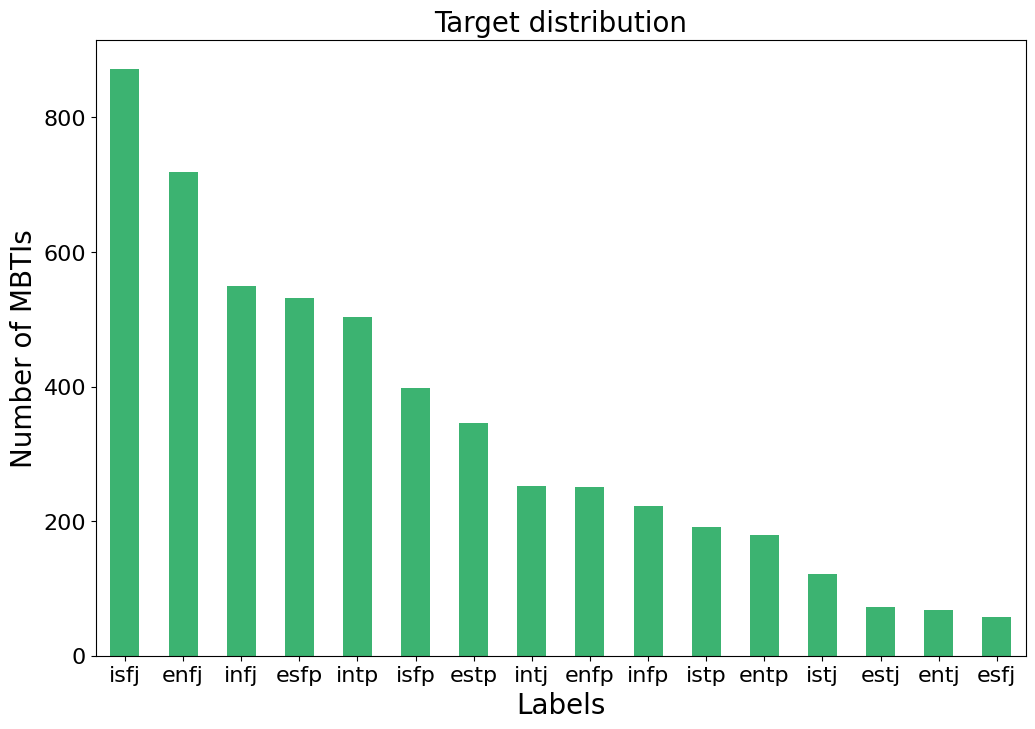

In [20]:
#Visualize the data
fig, ax = plt.subplots(figsize=(12,8))

train['label'].value_counts(sort=True).plot(kind='bar', color='mediumseagreen', fontsize = 16)
x = set(train['label'])

default_x_ticks = range(len(x))

plt.xticks(default_x_ticks, x, rotation=0, fontsize = 16)
plt.title('Target distribution', fontsize = 20)
plt.xlabel('Labels', fontsize = 20)
plt.ylabel('Number of MBTIs', fontsize = 20)

plt.show()

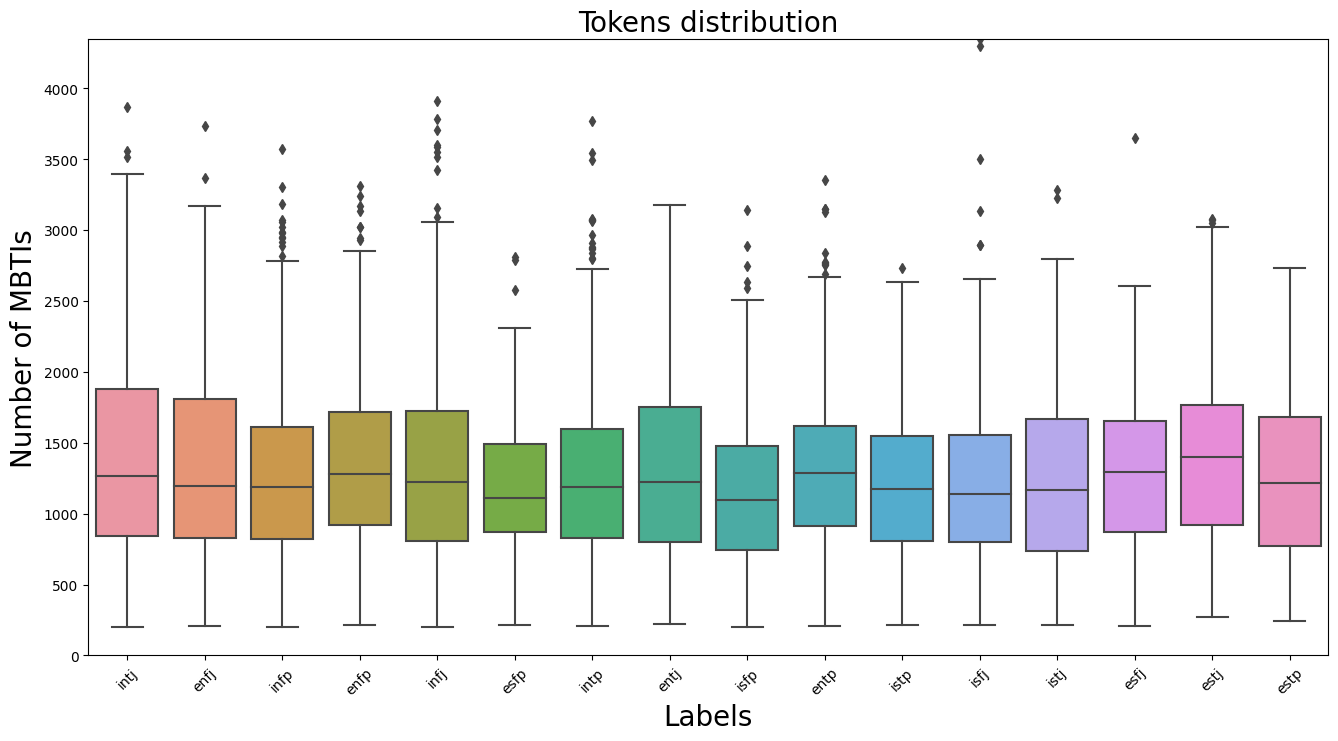

In [21]:
fig, ax = plt.subplots(figsize=(16, 8))

sns.boxplot(x='label', y='token_count', data=train)
plt.title('Tokens distribution', fontsize = 20)
plt.xlabel('Labels', fontsize = 20)
plt.ylabel('Number of MBTIs', fontsize = 20)
plt.ylim((0,train['token_count'].max()))
plt.xticks(rotation=45)
plt.show()

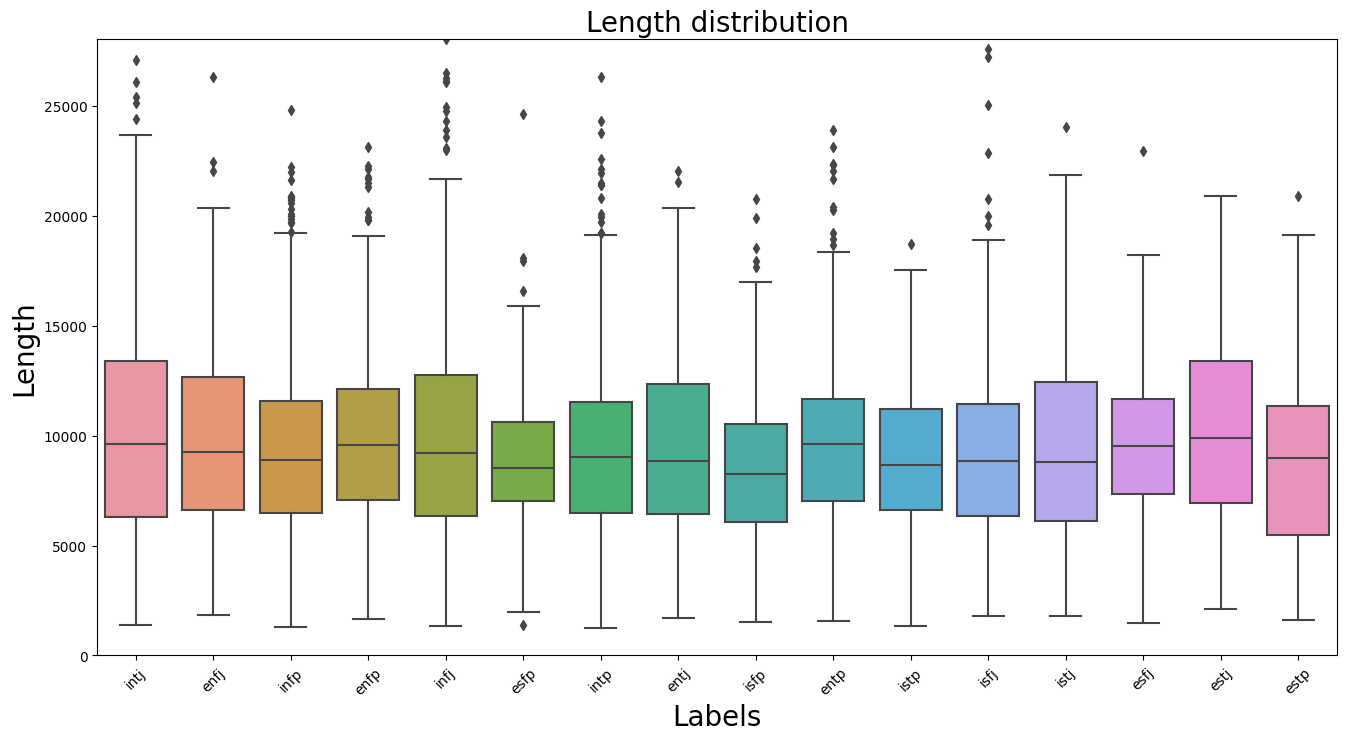

In [22]:
fig, ax = plt.subplots(figsize=(16, 8))

sns.boxplot(x='label', y='text_length', data=train)
plt.title('Length distribution', fontsize = 20)
plt.xlabel('Labels', fontsize = 20)
plt.ylabel('Length', fontsize = 20)
plt.ylim((0,train['text_length'].max()))
plt.xticks(rotation=45)
plt.show()

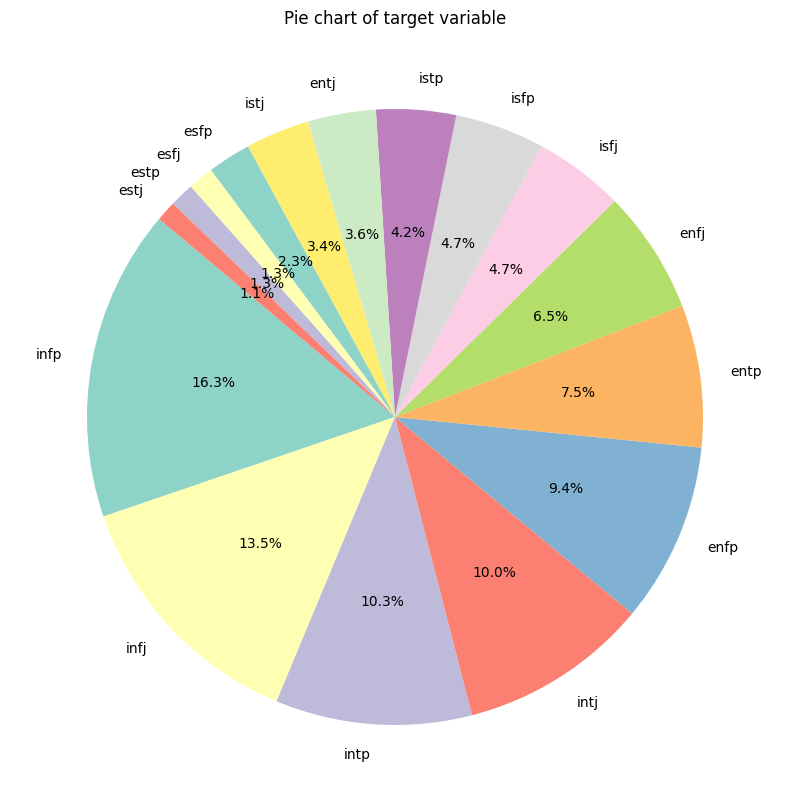

In [23]:
# Embarked town distribution pie chart
embark_counts = train['label'].value_counts()
plt.figure(figsize=(10,10))
plt.pie(embark_counts, labels=embark_counts.index, colors=sns.color_palette('Set3'), autopct='%1.1f%%', startangle=140)
plt.title('Pie chart of target variable')
plt.show()

In [24]:
sw1 = ["a","a's","able","about","above","according","accordingly","across","actually","after","afterwards","again","against","ain't","all","allow","allows","almost","alone","along","already","also","although","always","am","among","amongst","an","and","another","any","anybody","anyhow","anyone","anything","anyway","anyways","anywhere","apart","appear","appreciate","appropriate","are","aren't","around","as","aside","ask","asking","associated","at","available","away","awfully","b","be","became","because","become","becomes","becoming","been","before","beforehand","behind","being","believe","below","beside","besides","best","better","between","beyond","both","brief","but","by","c","c'mon","c's","came","can","can't","cannot","cant","cause","causes","certain","certainly","changes","clearly","co","com","come","comes","concerning","consequently","consider","considering","contain","containing","contains","corresponding","could","couldn't","course","currently","d","definitely","described","despite","did","didn't","different","do","does","doesn't","doing","don't","done","down","downwards","during","e","each","edu","eg","eight","either","else","elsewhere","enough","entirely","especially","et","etc","even","ever","every","everybody","everyone","everything","everywhere","ex","exactly","example","except","f","far","few","fifth","first","five","followed","following","follows","for","former","formerly","forth","four","from","further","furthermore","g","get","gets","getting","given","gives","go","goes","going","gone","got","gotten","greetings","h","had","hadn't","happens","hardly","has","hasn't","have","haven't","having","he","he's","hello","help","hence","her","here","here's","hereafter","hereby","herein","hereupon","hers","herself","hi","him","himself","his","hither","hopefully","how","howbeit","however","i","i'd","i'll","i'm","i've","ie","if","ignored","immediate","in","inasmuch","inc","indeed","indicate","indicated","indicates","inner","insofar","instead","into","inward","is","isn't","it","it'd","it'll","it's","its","itself","j","just","k","keep","keeps","kept","know","known","knows","l","last","lately","later","latter","latterly","least","less","lest","let","let's","like","liked","likely","little","look","looking","looks","ltd","m","mainly","many","may","maybe","me","mean","meanwhile","merely","might","more","moreover","most","mostly","much","must","my","myself","n","name","namely","nd","near","nearly","necessary","need","needs","neither","never","nevertheless","new","next","nine","no","nobody","non","none","noone","nor","normally","not","nothing","novel","now","nowhere","o","obviously","of","off","often","oh","ok","okay","old","on","once","one","ones","only","onto","or","other","others","otherwise","ought","our","ours","ourselves","out","outside","over","overall","own","p","particular","particularly","per","perhaps","placed","please","plus","possible","presumably","probably","provides","q","que","quite","qv","r","rather","rd","re","really","reasonably","regarding","regardless","regards","relatively","respectively","right","s","said","same","saw","say","saying","says","second","secondly","see","seeing","seem","seemed","seeming","seems","seen","self","selves","sensible","sent","serious","seriously","seven","several","shall","she","should","shouldn't","since","six","so","some","somebody","somehow","someone","something","sometime","sometimes","somewhat","somewhere","soon","sorry","specified","specify","specifying","still","sub","such","sup","sure","t","t's","take","taken","tell","tends","th","than","thank","thanks","thanx","that","that's","thats","the","their","theirs","them","themselves","then","thence","there","there's","thereafter","thereby","therefore","therein","theres","thereupon","these","they","they'd","they'll","they're","they've","think","third","this","thorough","thoroughly","those","though","three","through","throughout","thru","thus","to","together","too","took","toward","towards","tried","tries","truly","try","trying","twice","two","u","un","under","unfortunately","unless","unlikely","until","unto","up","upon","us","use","used","useful","uses","using","usually","uucp","v","value","various","very","via","viz","vs","w","want","wants","was","wasn't","way","we","we'd","we'll","we're","we've","welcome","well","went","were","weren't","what","what's","whatever","when","whence","whenever","where","where's","whereafter","whereas","whereby","wherein","whereupon","wherever","whether","which","while","whither","who","who's","whoever","whole","whom","whose","why","will","willing","wish","with","within","without","won't","wonder","would","wouldn't","x","y","yes","yet","you","you'd","you'll","you're","you've","your","yours","yourself","yourselves","z","zero"]
from nltk.corpus import stopwords
sw1 = set(sw1)
sw = stopwords.words("english")
sw = set(sw)
STOPWORDS = set.union(sw1, sw)

# source https://github.com/6/stopwords-json/blob/master/dist/en.json

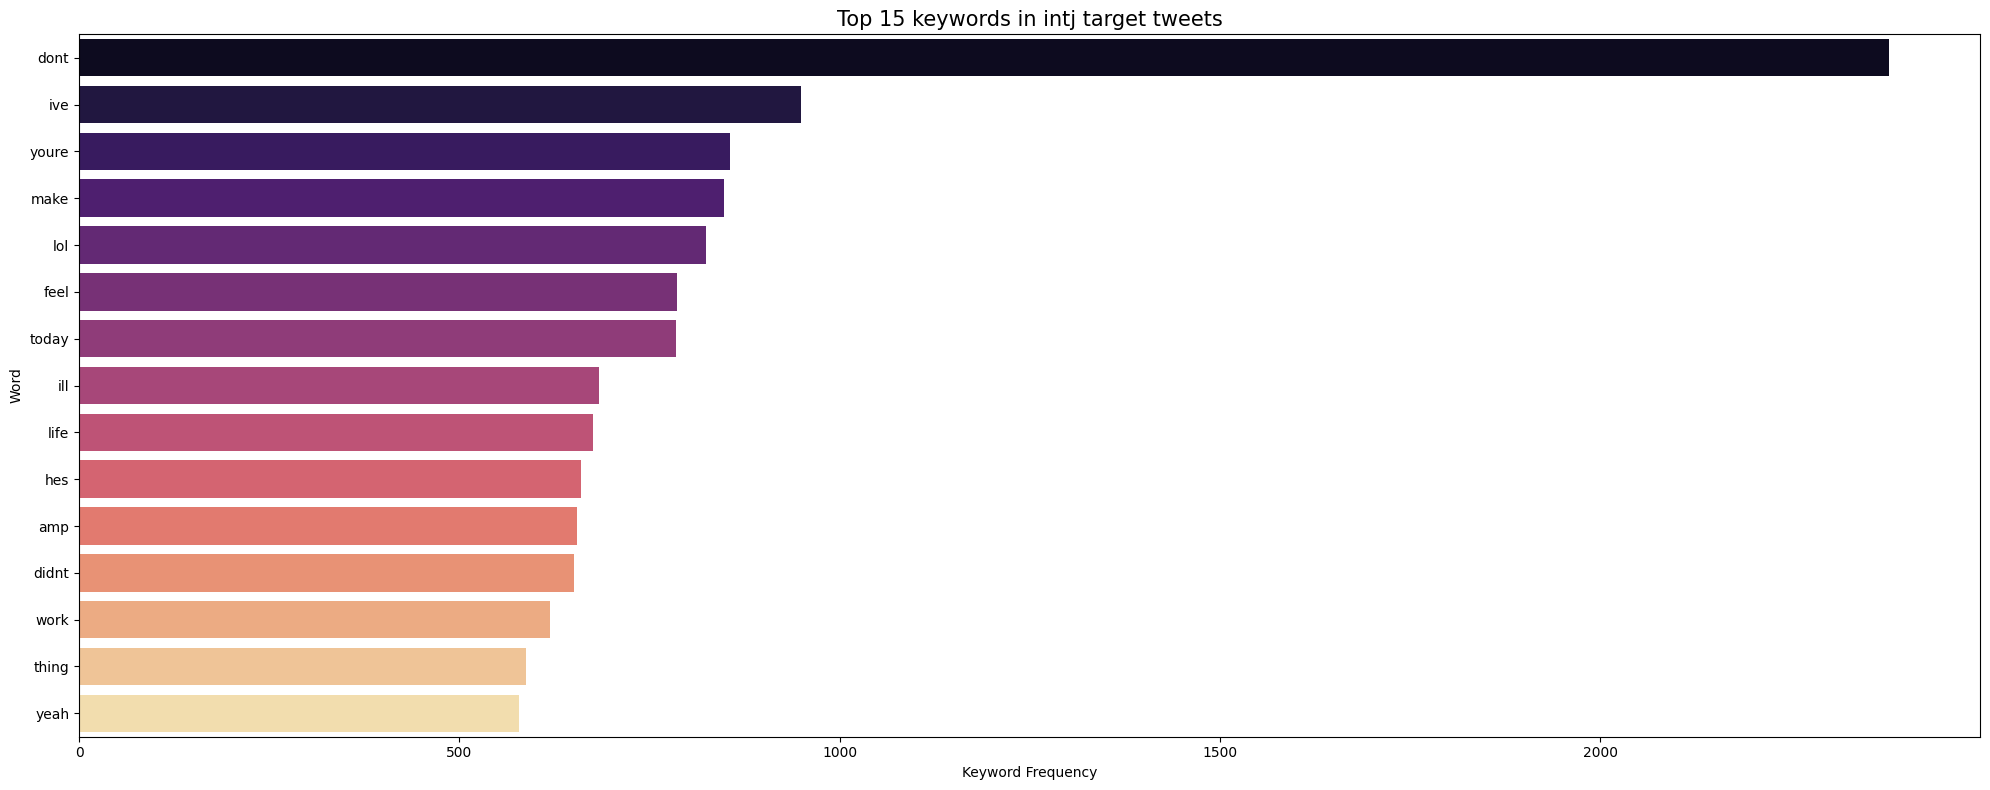

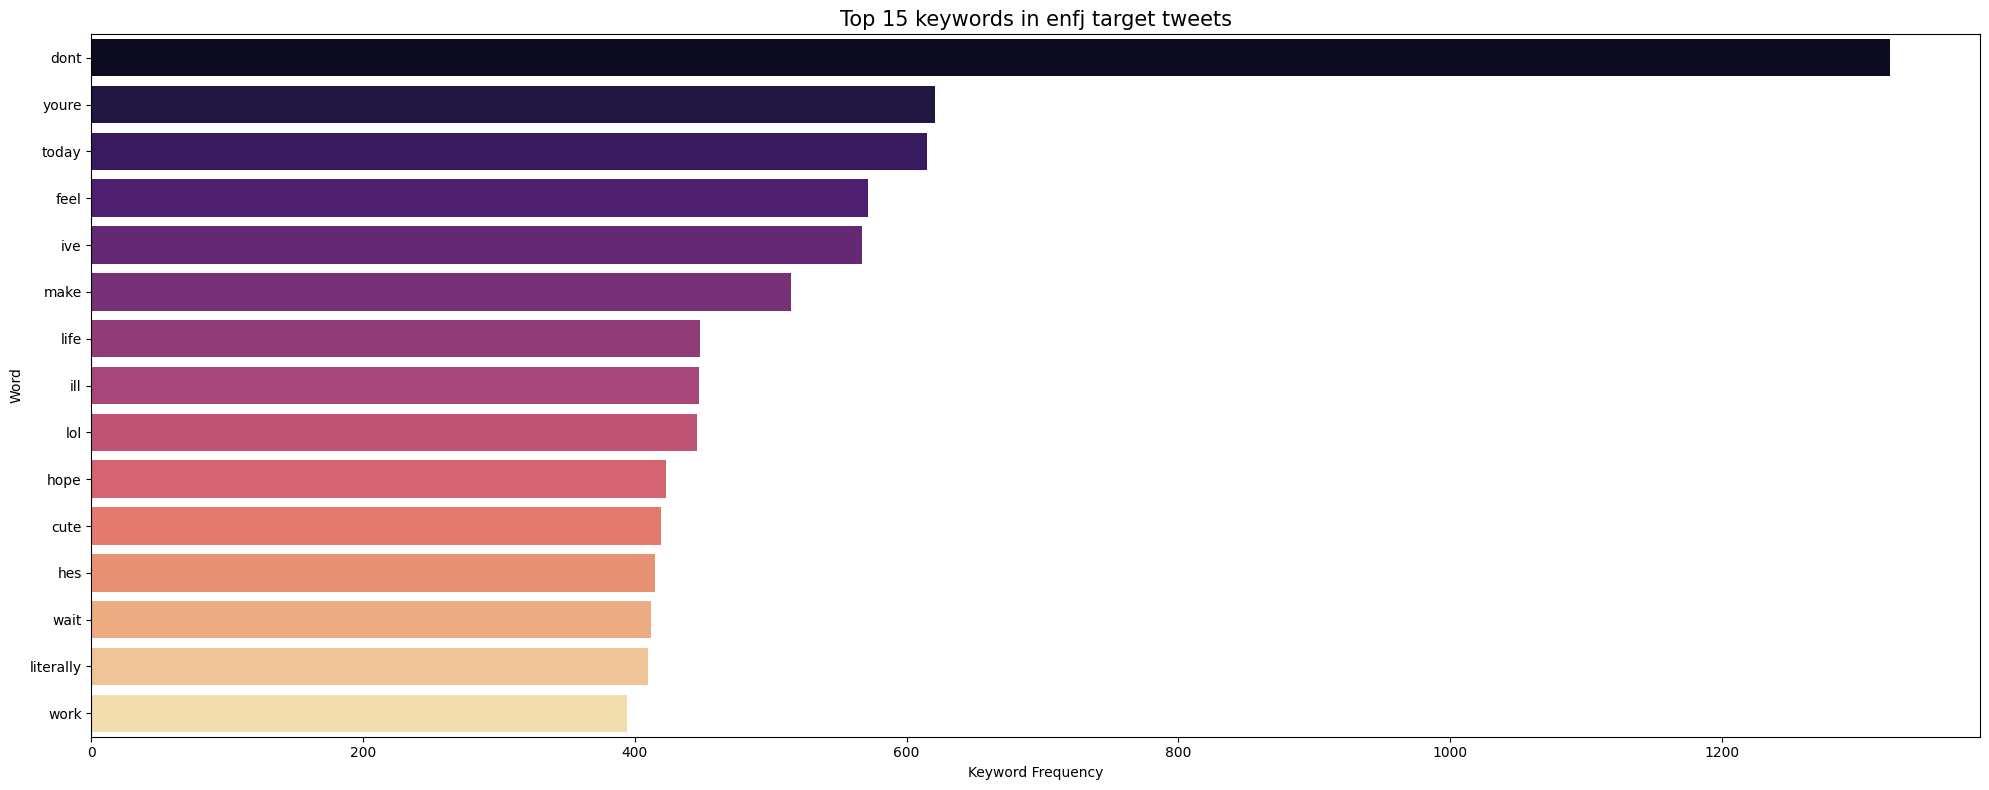

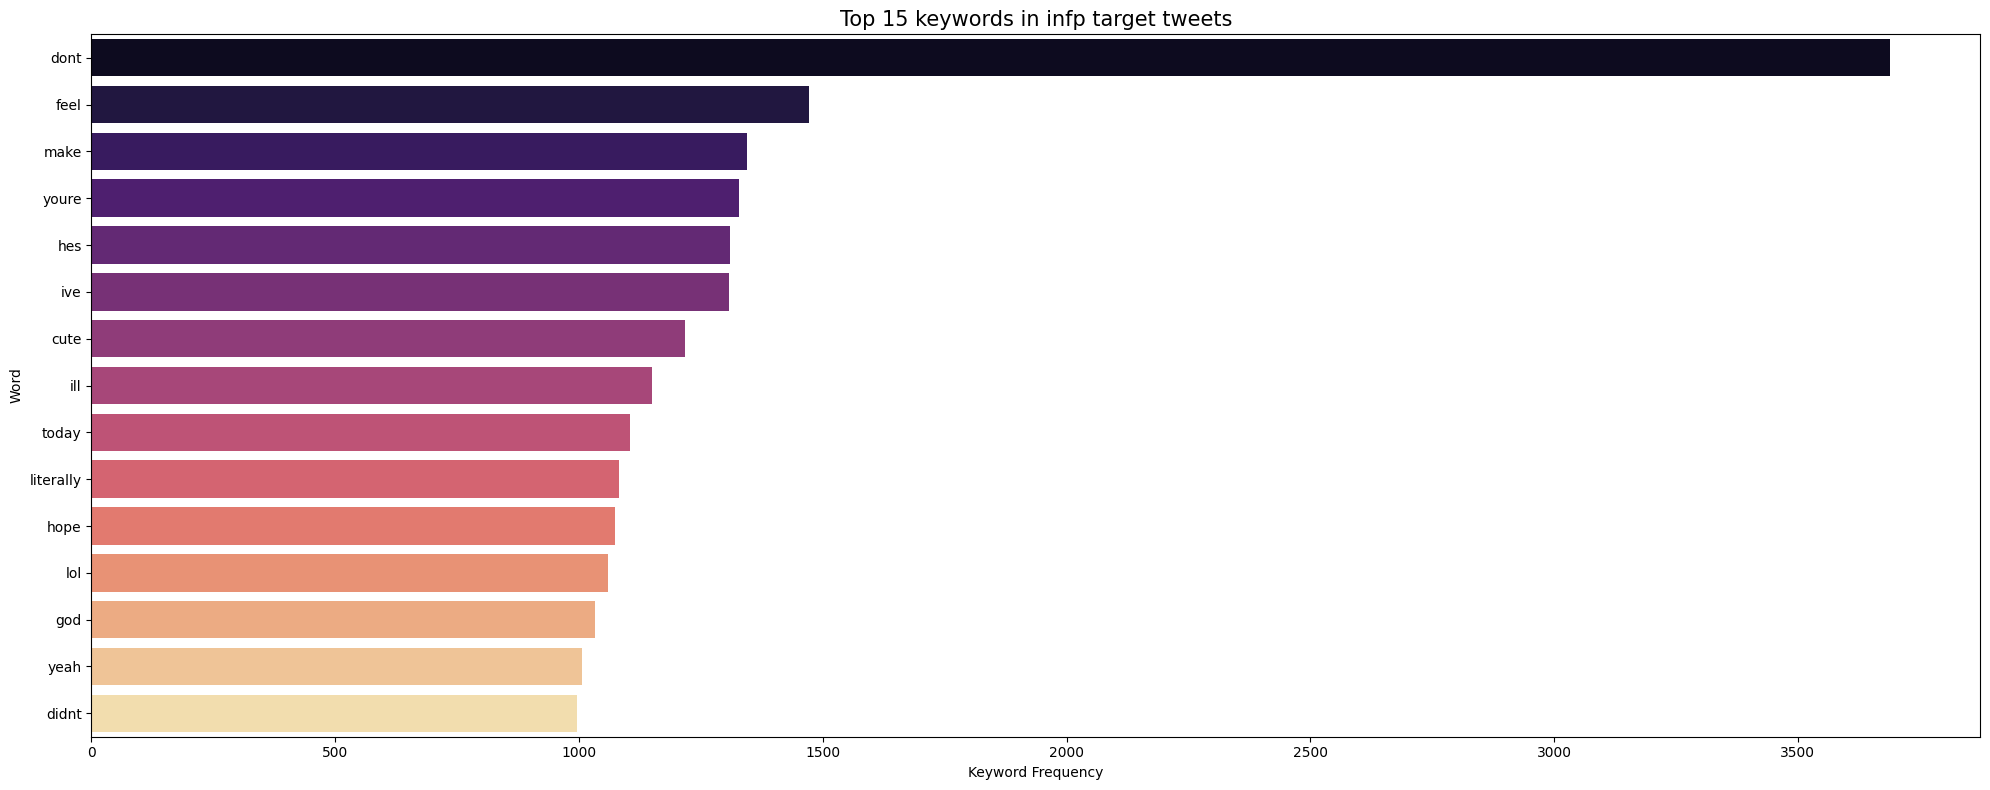

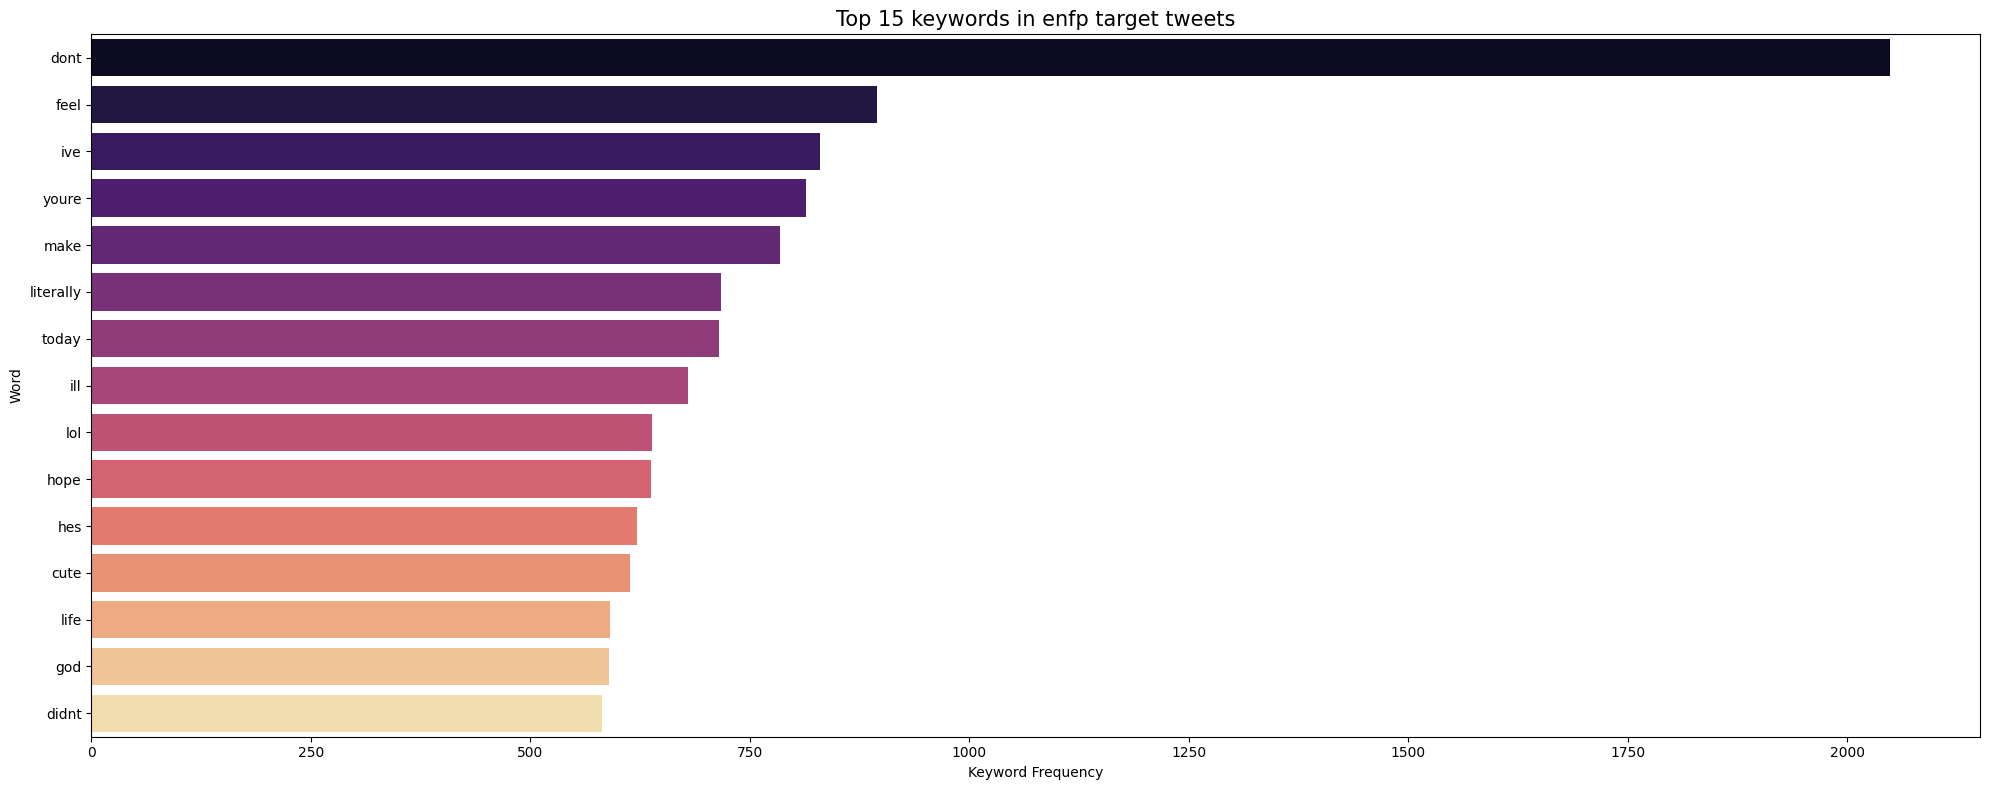

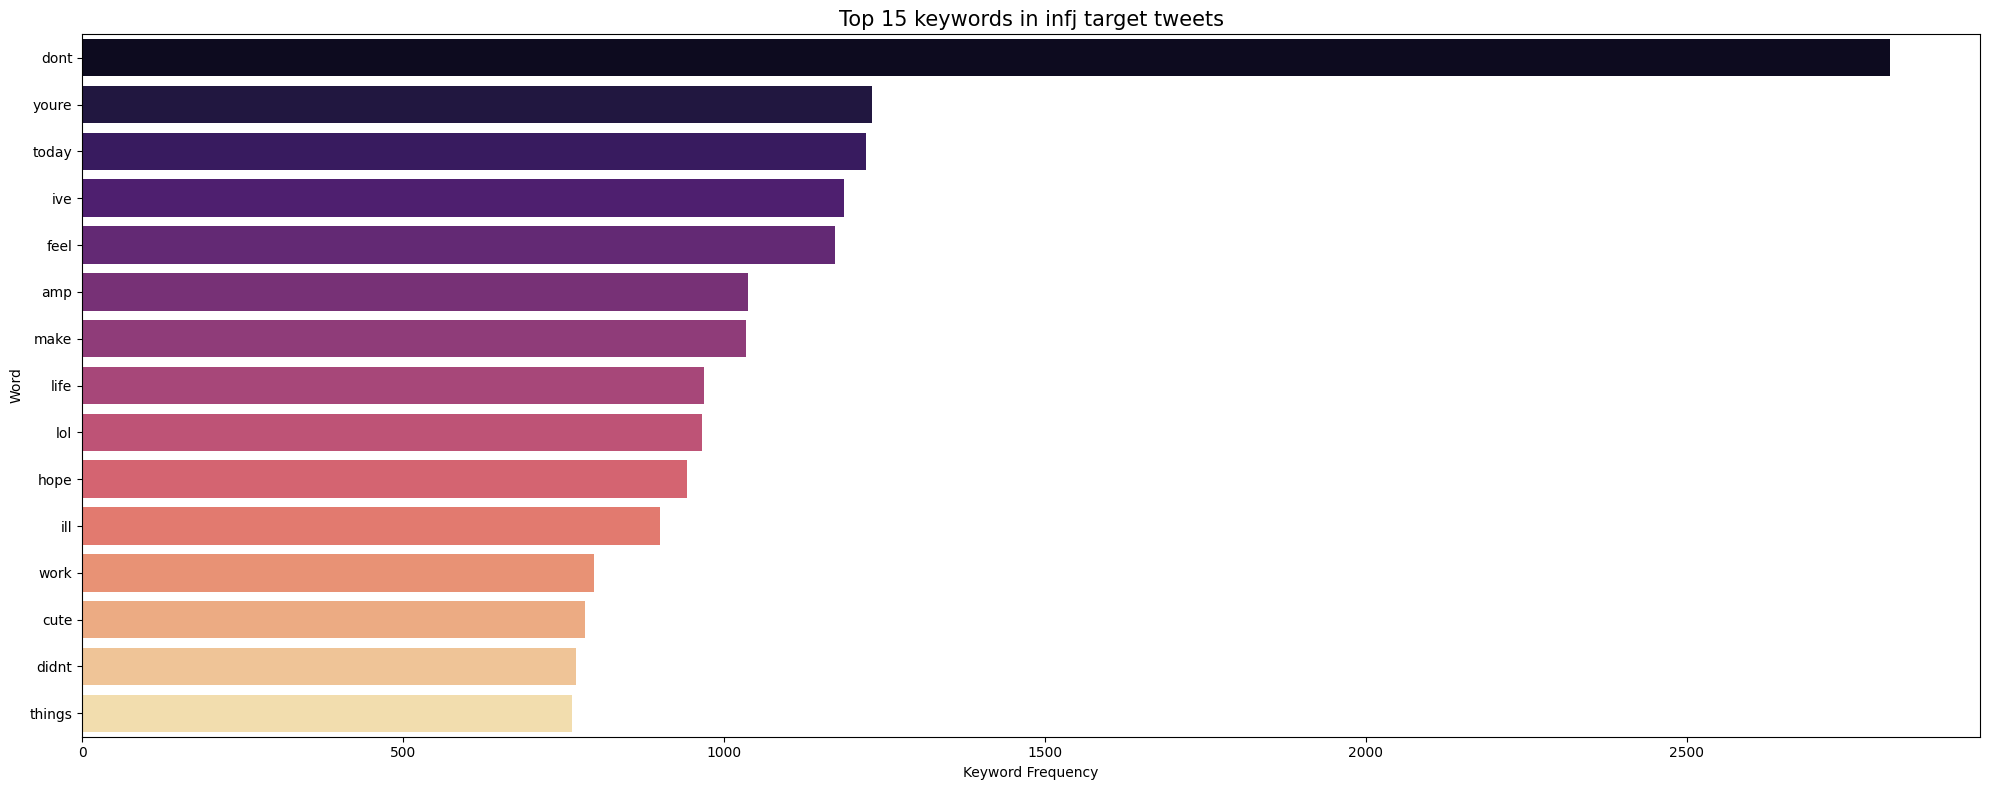

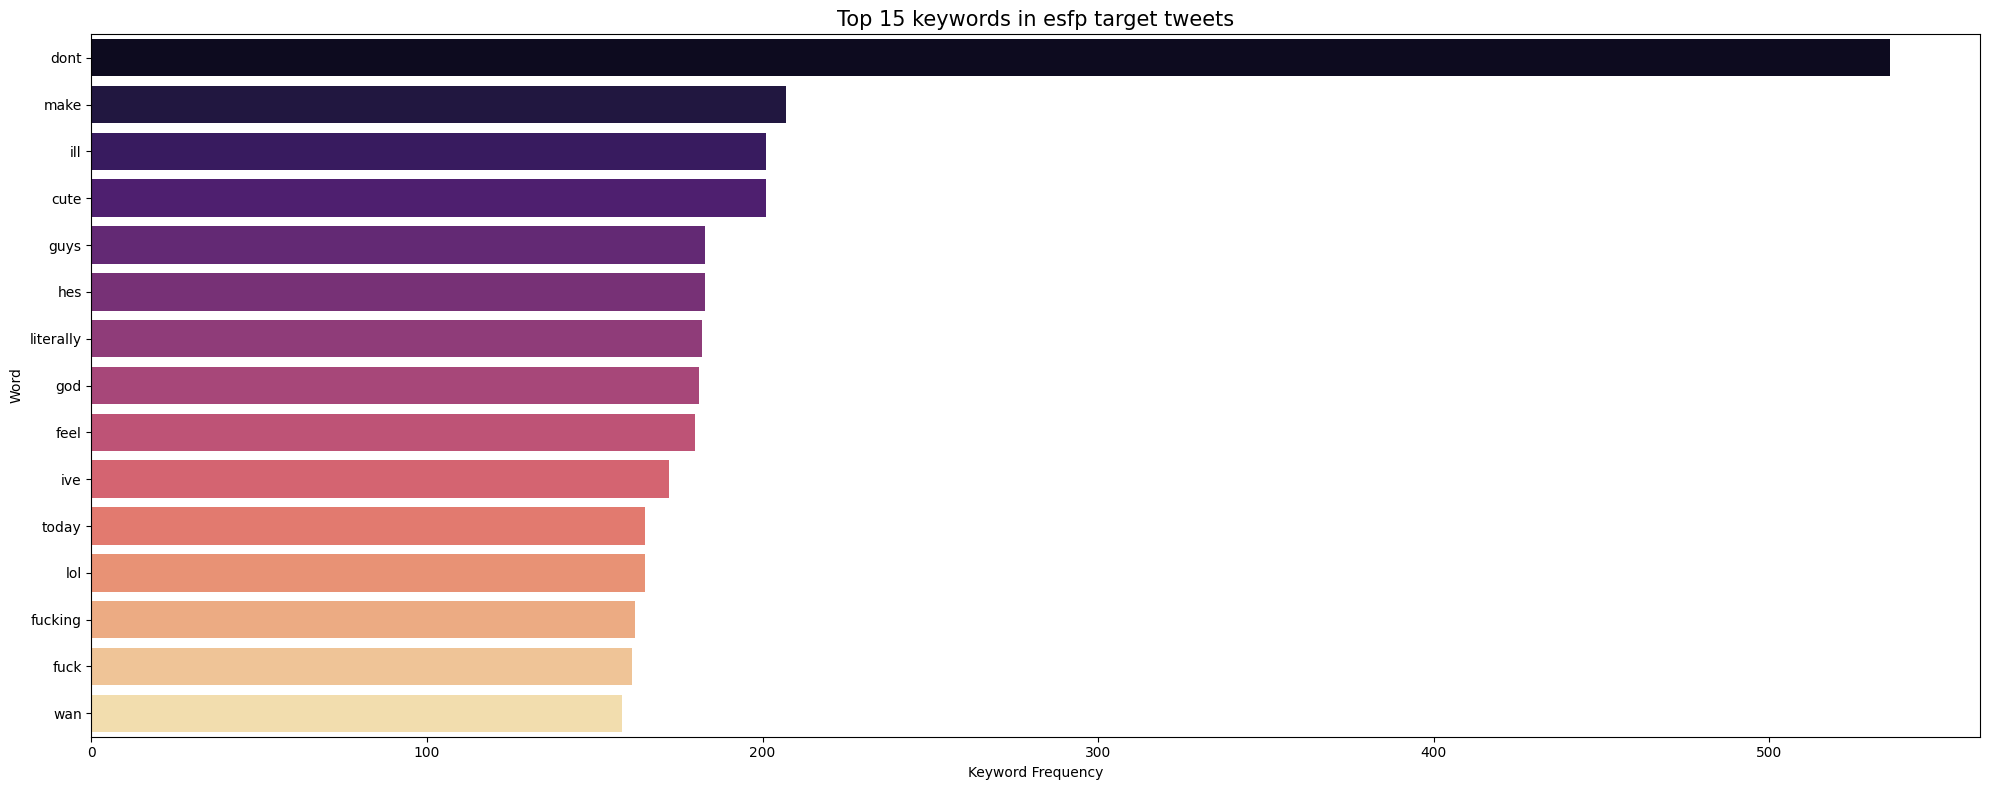

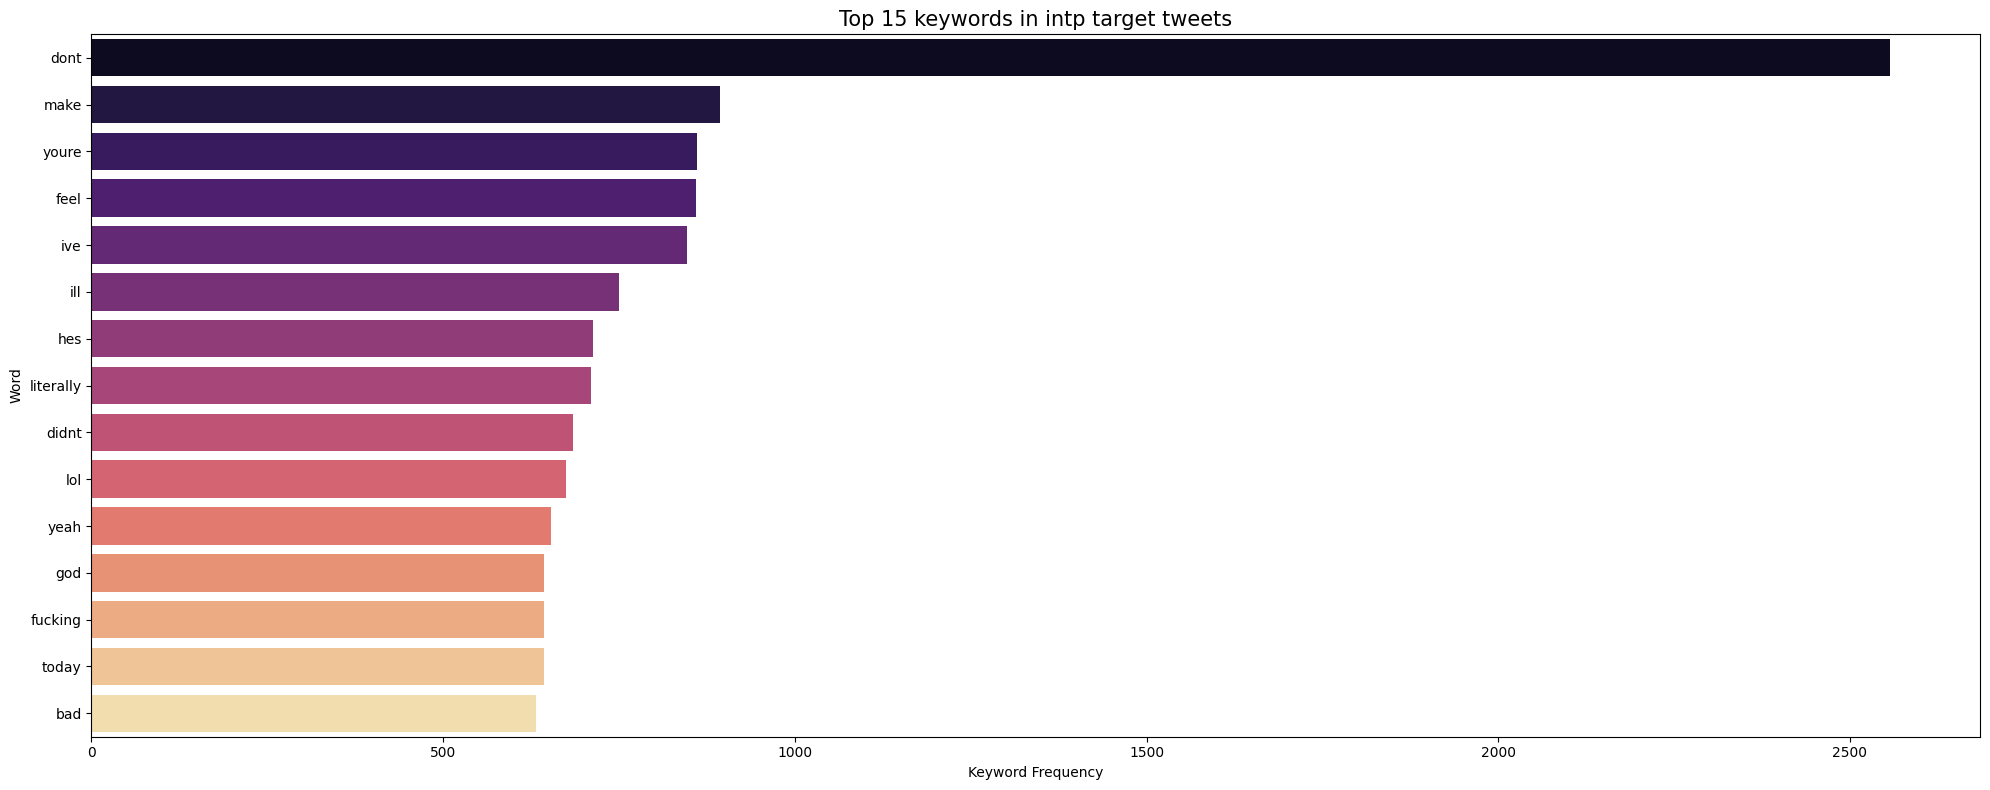

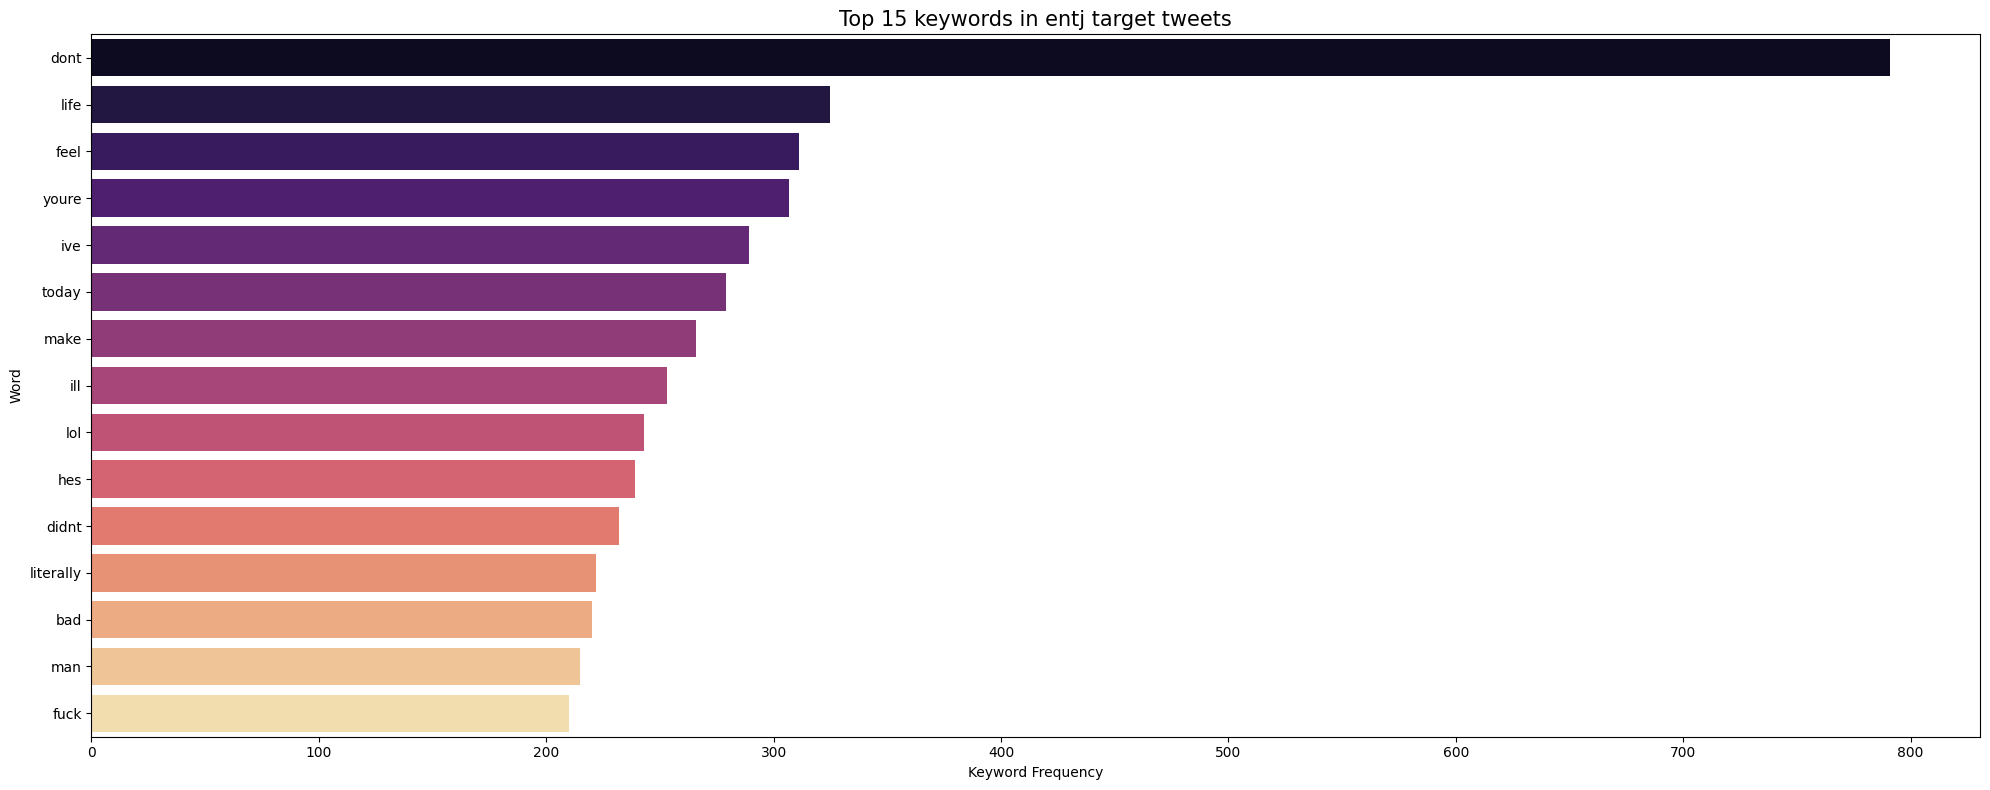

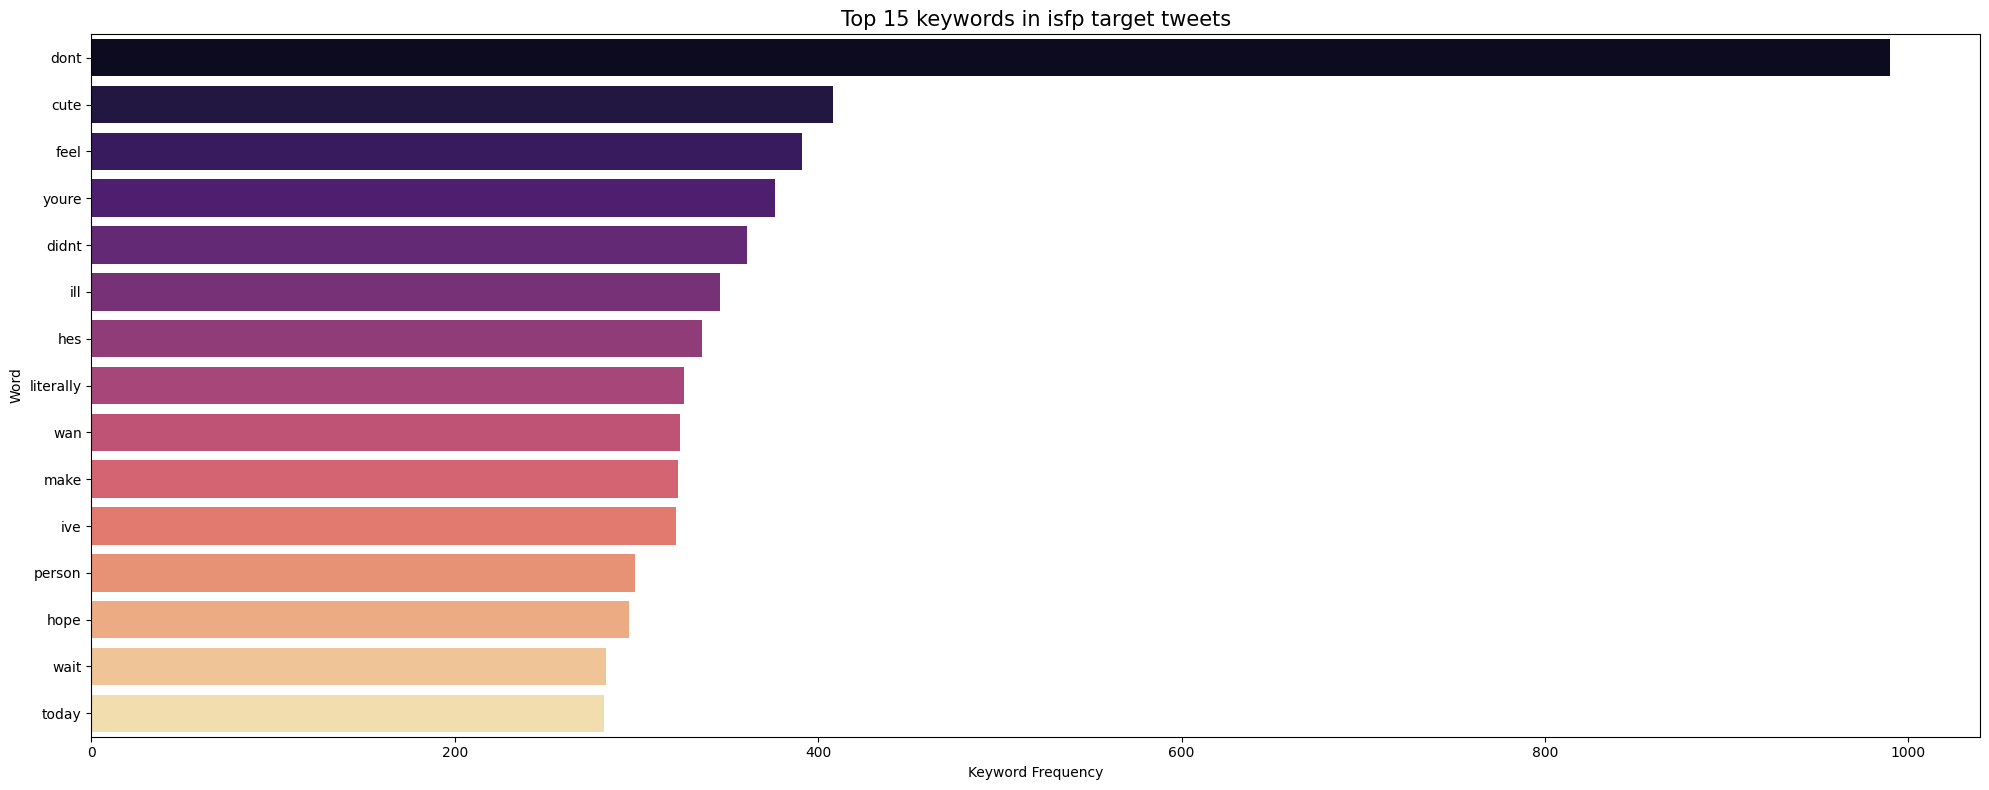

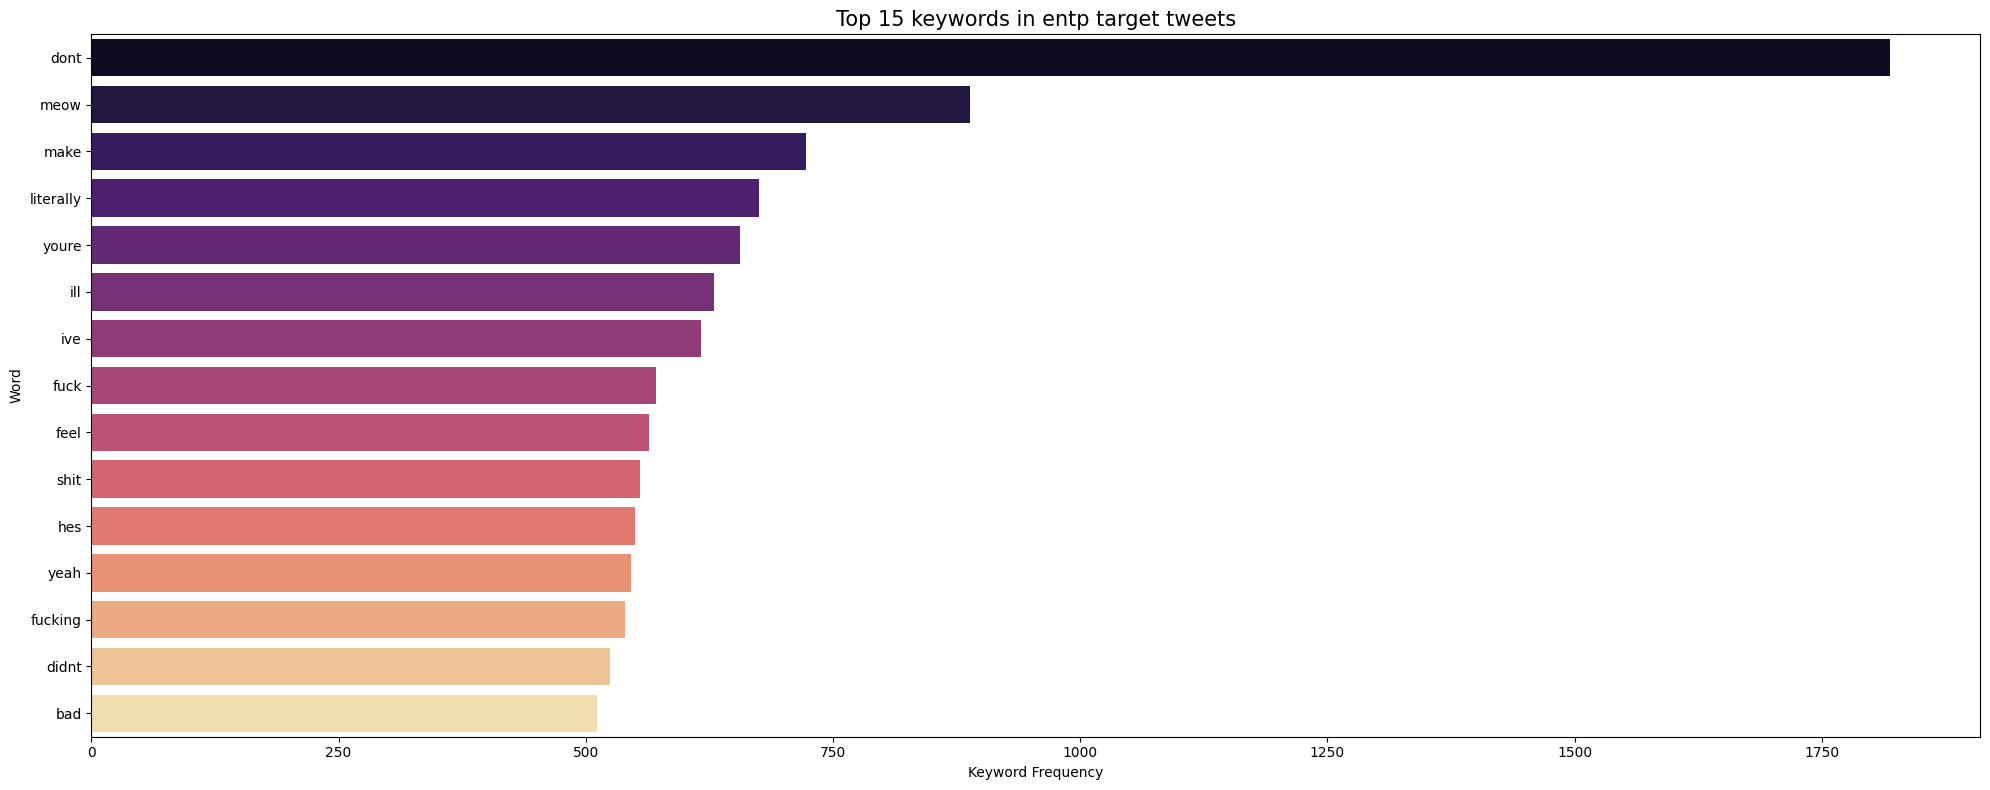

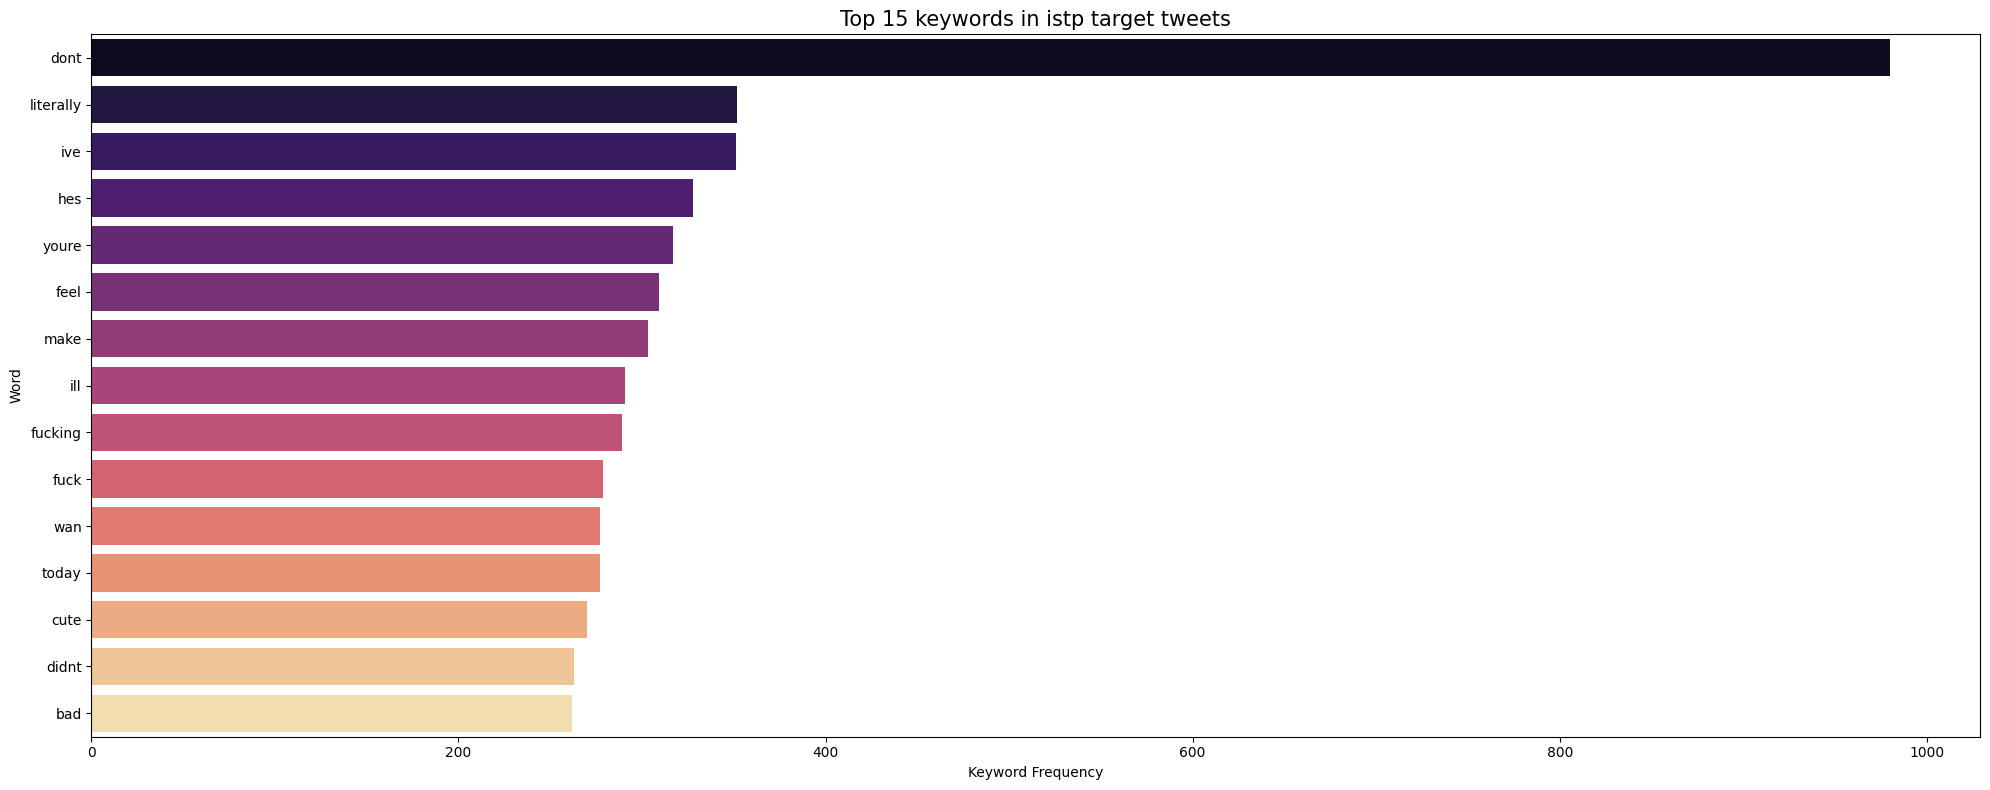

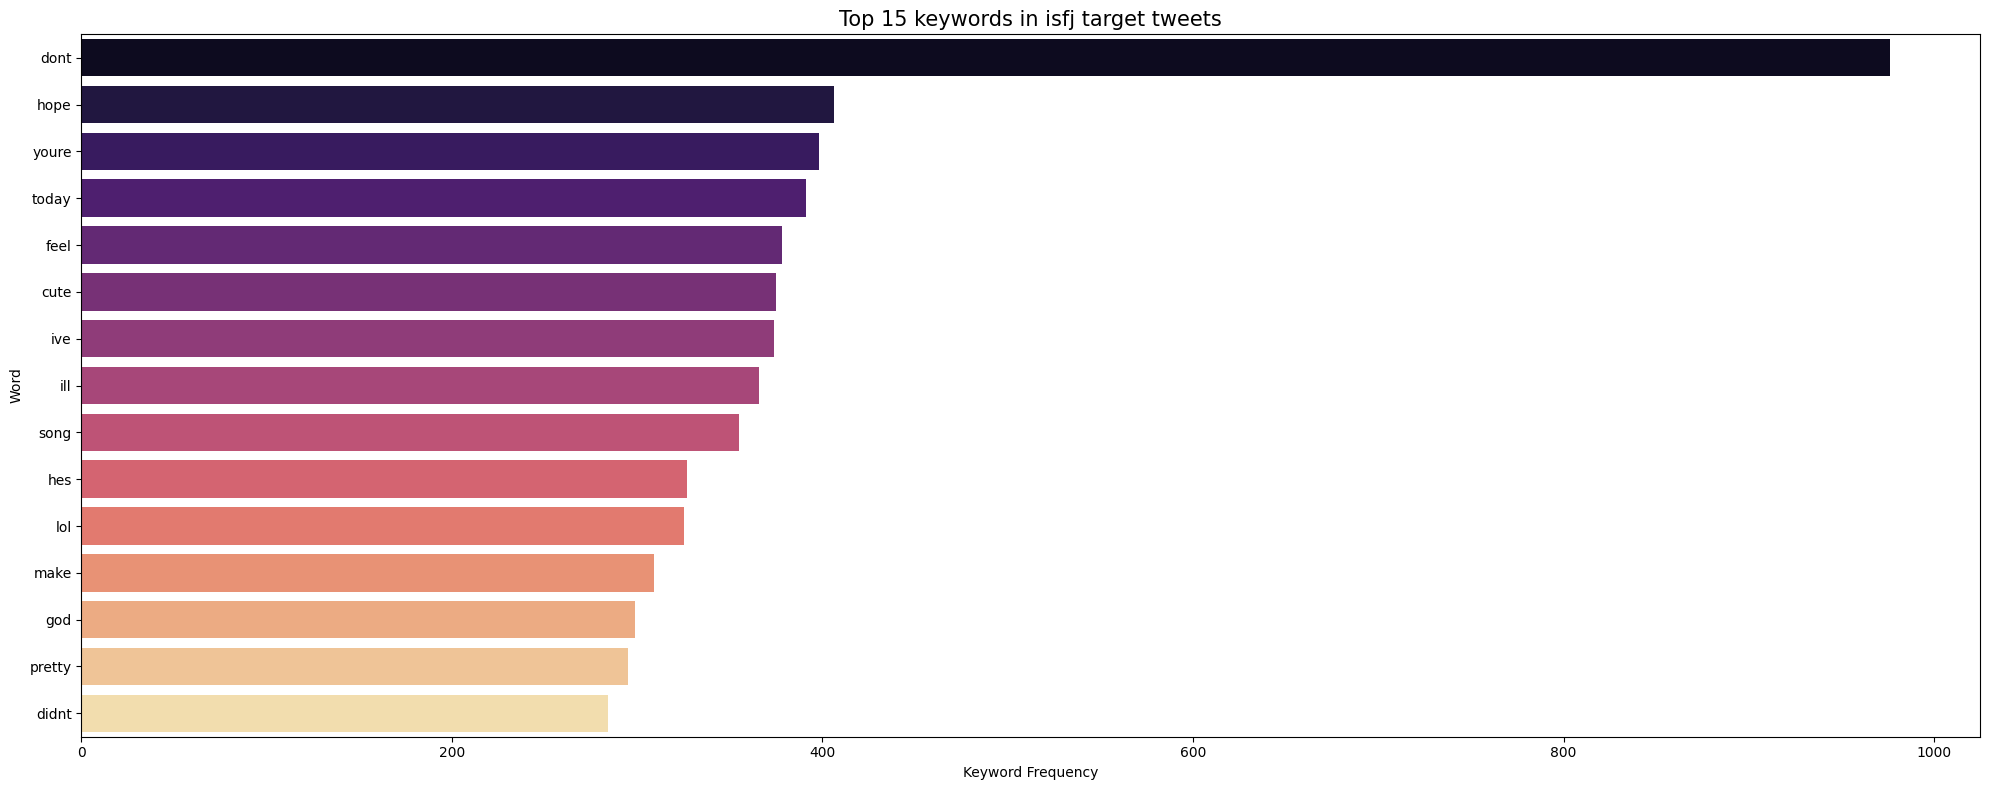

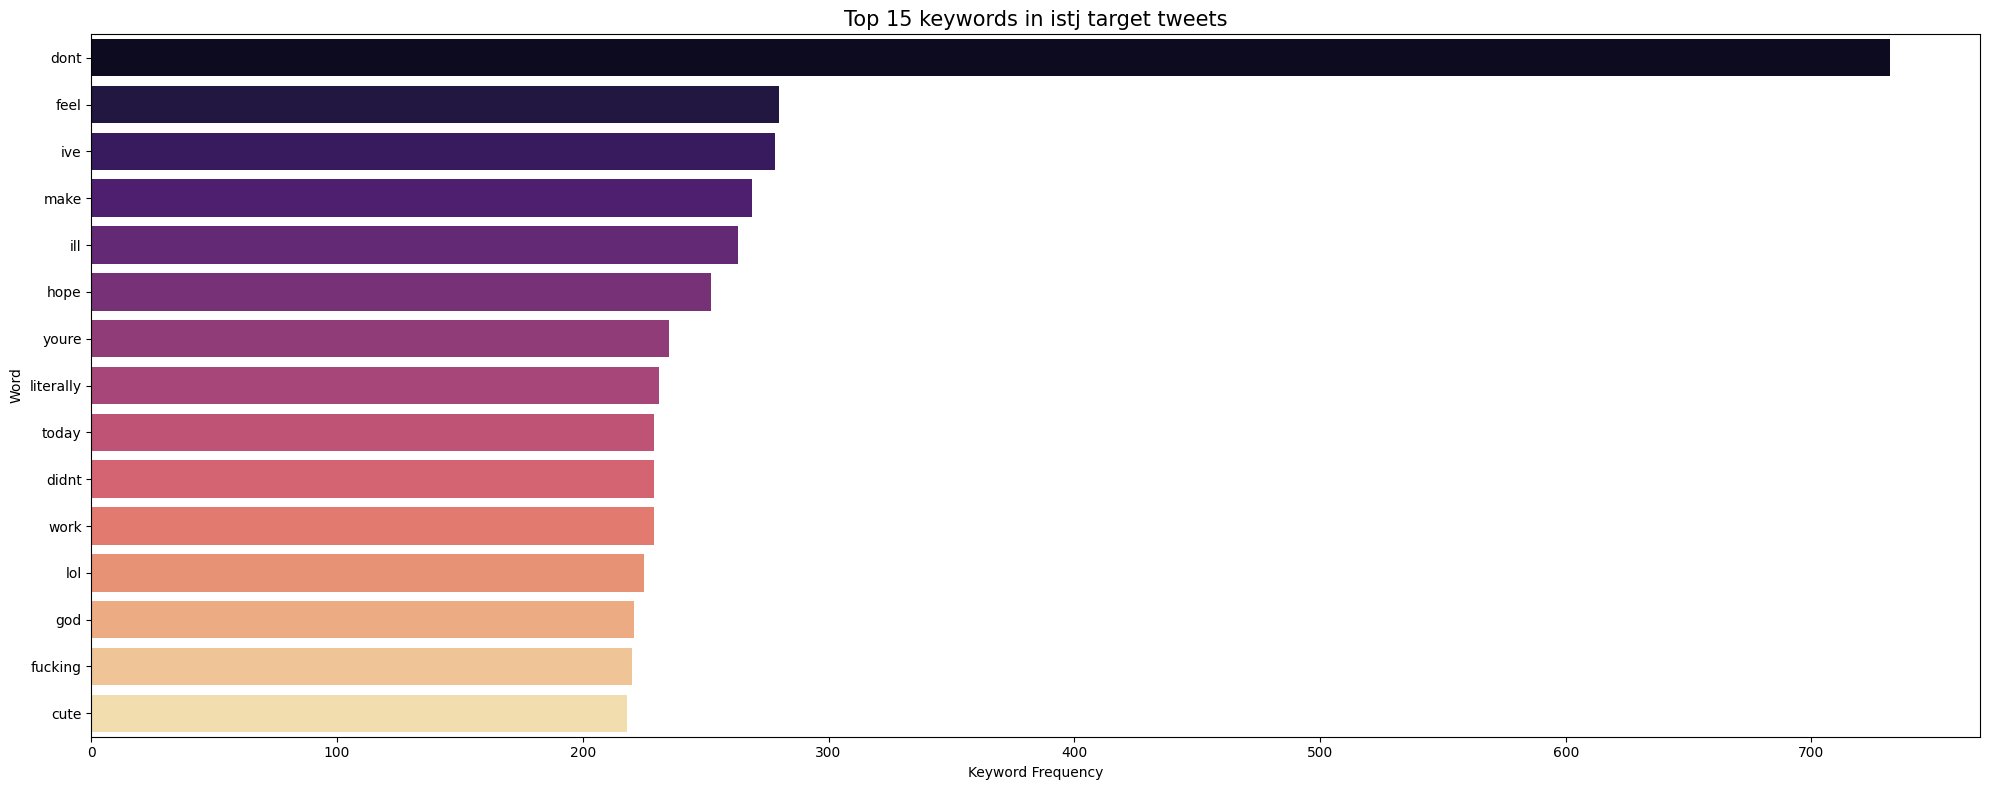

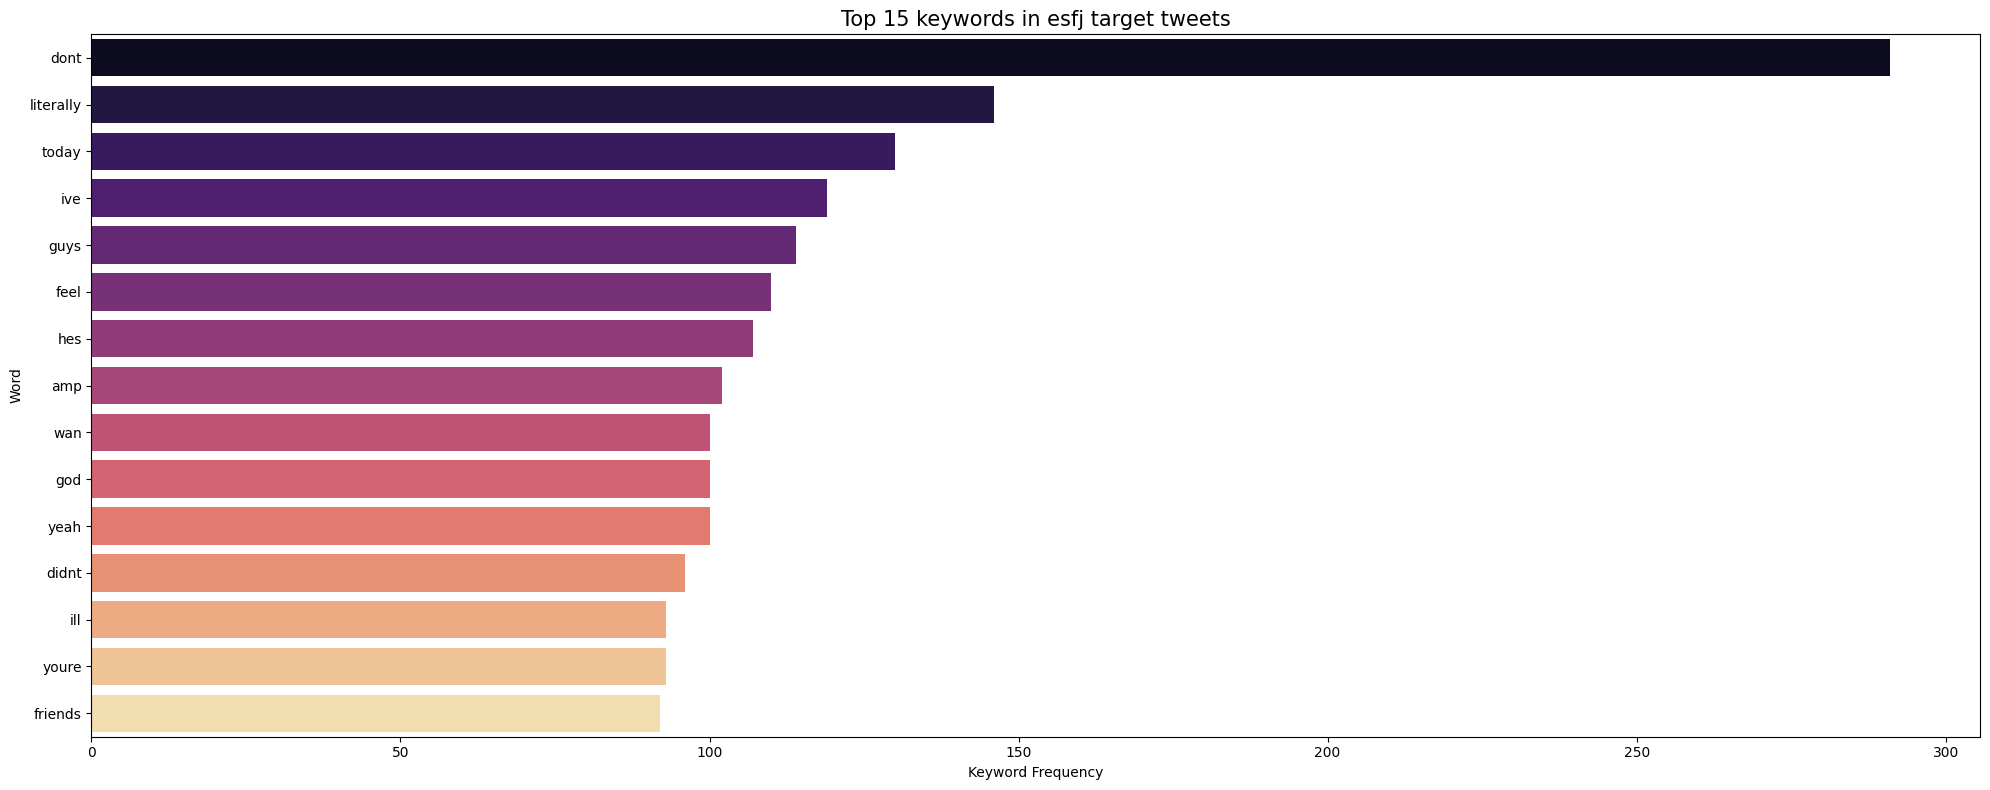

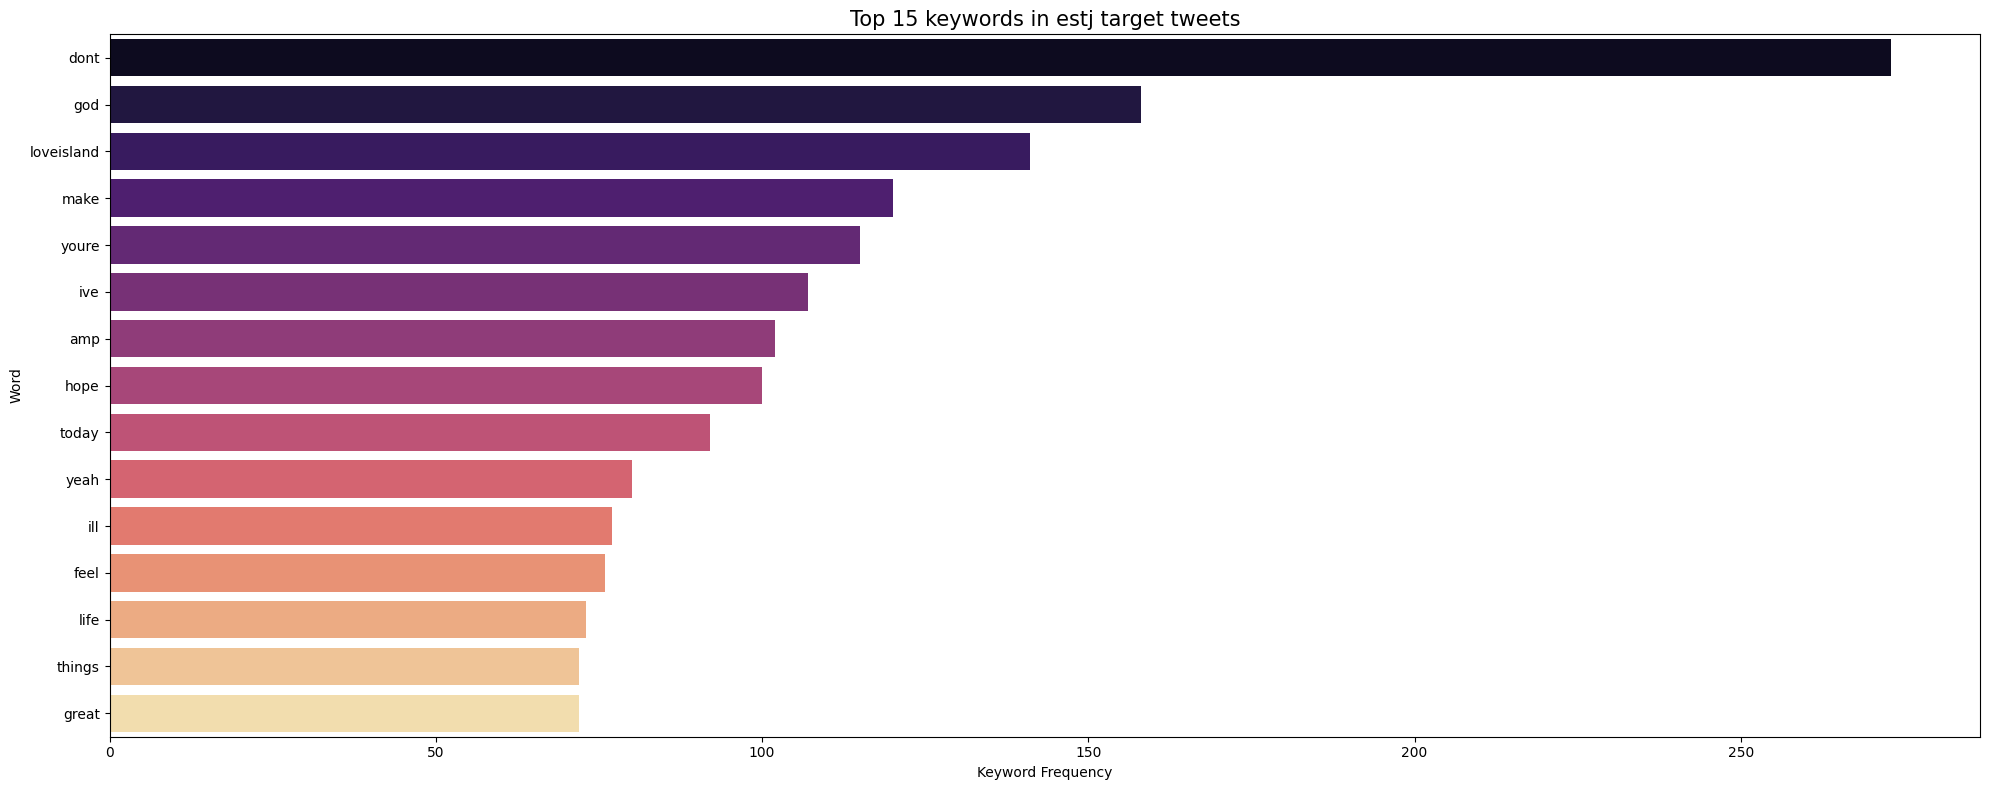

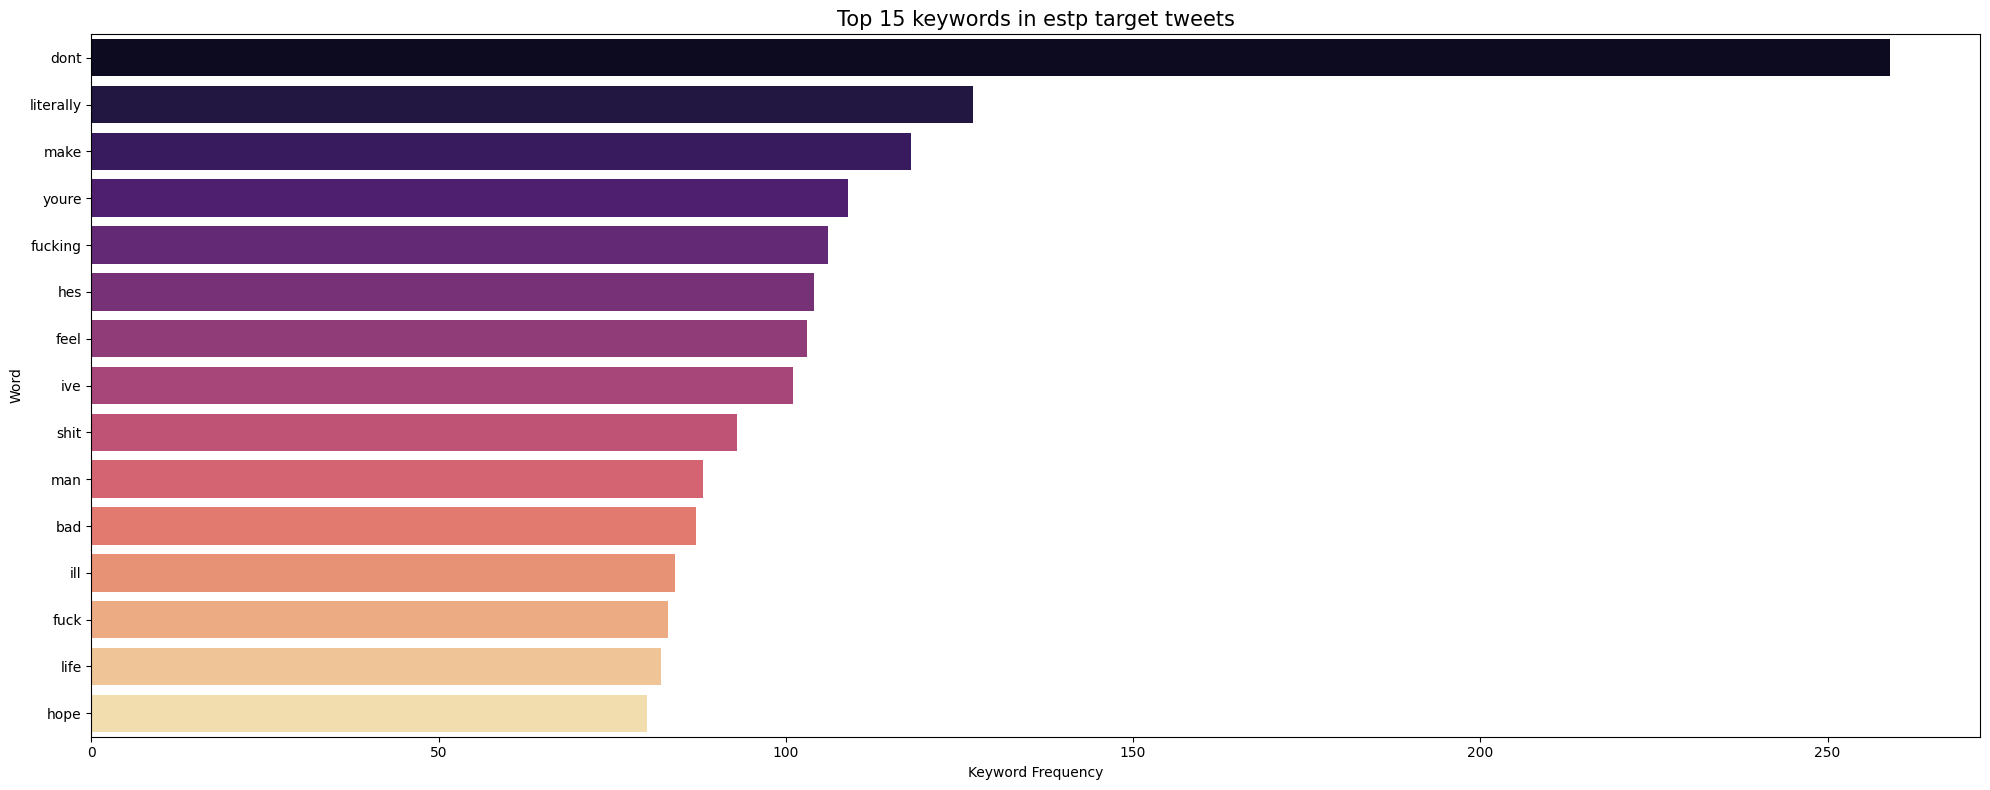

In [25]:
# noisy words
UNWANTED_WORDS = set([
    "i", "it", "ur", "na", "omg", "people", "time", "good", "back", "gon", "day", "love", "happy", "lt", "kst", 'im'
])

for l in train['label'].unique():
    label_text = " ".join(" ".join(cat) for cat in train[train.label == l]['text']) # join inside lists then make it as a whole string

    words = nltk.tokenize.word_tokenize(label_text)
    
    filtered_words = [
        w for w in words if w.isalnum() and w not in STOPWORDS and w.lower() not in UNWANTED_WORDS
    ]
    
    label_keywords = nltk.FreqDist(filtered_words)
    label_keywords = pd.DataFrame(label_keywords.most_common(15), columns=['Word', 'Frequency']).set_index('Word')

    fig, ax = plt.subplots(figsize=(20, 8))
    sns.barplot(y=label_keywords[0:15].index, x=label_keywords[0:15].Frequency, orient='h', ax=ax, palette="magma")

    # settings
    ax.set_title(f'Top 15 keywords in {l} target tweets', fontsize=15)
    ax.set_xlabel('Keyword Frequency')

    plt.tight_layout()
    plt.show()